# IBM Capstone Project: The Battle of the Neighborhoods

### Open new Park in Toronto

<h2>Introduction/Business Problem </h2>

In this Lab you will load the table of postal codes and to transform the data into a pandas dataframe using beautifulsoup4 and match it with ohther Geographic information 

##### Introduction
Toronto is the provincial capital of Ontario and the most populous city in Canada, with a population of 2,731,571 in 2016. Current to 2016, the Toronto census metropolitan area (CMA), of which the majority is within the Greater Toronto Area (GTA), held a population of 5,928,040, making it Canada's most populous CMA. The city is the anchor of the Golden Horseshoe, an urban agglomeration of 9,245,438 people (as of 2016) surrounding the western end of Lake Ontario.

##### Business Problem
Toronto is an international center of business, finance, arts, and culture, and is recognized as one of the most multicultural and cosmopolitan cities in the world.
So A group of investors is looking to open an new Park in Toronto, and ask to recommend where to open? 
##### In this Project We should look for a best place where we have a maximum of Population and the minimum of Park around.

<h2>Data Section</h2>
Here we will use Open Source data from Wikipedia to get Demographic Data : https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods and Foursquare API to get all geographic information about Neighbourhoods by folowwing these Steps 


<div class="alert alert-block alert-info" style="margin-top: 20px">
<ol>
    <li><a href="#1">1- Scrapping Wikipedia to get Toronto Demographic Data and Focus on Population Only</a></li>
    <li><a href="#2">2- Geocoding our Dataset using the name of each District to be used in Foursquare API</a></li>
    <li><a href="#3">3- Using the Foursquare API to explore toronto Districts to get venues.</a></li>
    <li><a href="#4">4- Analyzing our Data, cleaning, and Featuring (like getting the number of Parks in each District)</a></li>
    <li><a href="#5">5- Clustering Districts using k-means clustering to choose in which cluster we will choose our district</a></li>
    <li><a href="#6">6- Using the Folium library to visualize the neighborhoods, venues , clusters in toronto</a></li>
</ol>
    
Estimated Time Needed: <strong>20 hours</strong>
</div>
 
<hr>

Lets load required libraries

In [2]:
import pandas as pd
import numpy as np
import requests
import lxml.html as lh
import folium

<div id="1">
    <h2>1- Scrapping Wikipedia to get Demographic Data and Focus on Population Only</h2> 
</div>

Lets download the dataset. To download the data, we will use beautifulsoup4

In [3]:
#Demographics of Toronto neighbourhoods
url="https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods"
dfs = pd.read_html(url)
print(len(dfs))

6


In [4]:
df = dfs[1]
df=df[["Name","Population"]]
df=df[df["Name"]!="Toronto CMA Average"]
df.describe()

,Population
count,174.000000
mean,13883.758621
std,10319.218850
min,548.000000
25%,6258.000000
50%,11279.000000
75%,17705.500000
max,52220.000000


##### We got 174 rows representing neighbohoods in Toronto with name of each neighbor and its population 

In [5]:
df.head()

,Name,Population
1,Agincourt,44577
2,Alderwood,11656
3,Alexandra Park,4355
4,Allenby,2513
5,Amesbury,17318


<div id="2">
    <h2>2- Geocoding our Dataset using the name of each District to be used in Foursquare</h2> 
</div>

Get the Geographic coordinates

In [7]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

#If Location found it's ok!
#Else we generate (0,0)

def get_geocoder(name_from_df):
    address = '{}, Toronto, Ontario'.format(name_from_df)
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    if(location !=None):
      return location.latitude, location.longitude
    else:
        return 0, 0

In [9]:
coords = [ get_geocoder(name) for name in df["Name"].tolist() ]

In [12]:
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df['Latitude'] = df_coords['Latitude']
df['Longitude'] = df_coords['Longitude']
print("Geographical coordinates of five neighborhoods are as below")
df.head()

Geographical coordinates of five neighborhoods are as below


,Name,Population,Latitude,Longitude
1,Agincourt,44577,43.601717,-79.545232
2,Alderwood,11656,43.650787,-79.404318
3,Alexandra Park,4355,43.711351,-79.553424
4,Allenby,2513,43.706162,-79.483492
5,Amesbury,17318,43.743944,-79.430851


In [35]:
#We can use a loop to persist on finding Cordinnates and it works but here i choose to not do it and just eliminate districts not geolocated
df=df[df["Latitude"]!=0]

In [36]:
df[df["Longitude"]==0]

,Name,Population,Latitude,Longitude


In [37]:
print(df.shape)
#So we will work with 163 Neighbor

(163, 4)


### Visualizing these Neighbours or districts in a Map

In [38]:
# create map of Toronto using latitude and longitude values (from Internet or by using geopy library)
"""
address = 'Toronto, Canada'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)
"""

# OR just search them in internet
#Toronto Lat/Long
toro_longitude=-79.3831843
toro_latitude=43.653226

In [41]:
# create map zoomin on toronto
map = folium.Map(location=[toro_latitude, toro_longitude], zoom_start=10)

In [40]:
# add markers to map and let's map our Neighbours
for lat, lng, name in zip(df['Latitude'], df['Longitude'], df['Name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
    
map

<div id="3">
    <h2>3- Using the Foursquare API to explore toronto Districts to get venues.</h2> 
</div>

#### Define Foursquare Credentials and Version

In [44]:
CLIENT_ID = 'xxMaskxx' # your Foursquare ID
CLIENT_SECRET = 'xxMaskxx' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
radius = 500
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: S1BCO3PQ40KKAMECPDFNEXKSTKZFAXLNRGA3L3UJ1NP0ENZV
CLIENT_SECRET:4KYFOMWOWWLLKMLVDZPXZSOS3D1MDZTYKGC2BVOXJ5UKLEXA


In [42]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Name', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'VenueLatitude', 
                  'VenueLongitude', 
                  'VenueCategory']
    
    return(nearby_venues)

In [45]:
#Getting Neighbours for each element in our dataset
toronto_venues = getNearbyVenues(names=df['Name'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude'],
                                  )

In [46]:
toronto_venues.head()

,Name,Latitude,Longitude,Venue,VenueLatitude,VenueLongitude,VenueCategory
0,Agincourt,43.601717,-79.545232,Il Paesano Pizzeria & Restaurant,43.601280,-79.545028,Pizza Place
1,Agincourt,43.601717,-79.545232,Timothy's Pub,43.600165,-79.544699,Pub
2,Agincourt,43.601717,-79.545232,Toronto Gymnastics International,43.599832,-79.542924,Gym
3,Agincourt,43.601717,-79.545232,Tim Hortons,43.602396,-79.545048,Coffee Shop
4,Agincourt,43.601717,-79.545232,Pizza Pizza,43.605340,-79.547252,Pizza Place


<div id="4">
    <h2>4- Analyzing our Data, cleaning, and Featuring (like getting the number of Parks in each District)</h2> 
</div>

In [47]:
print('There are {} unique venue categories but we are interesed just By "Park Category":'.format(len(toronto_venues['VenueCategory'].unique())))

There are 287 unique venue categories but we are interesed just By "Park Category":


In [52]:
print('Top 5 distinct venue counts are as below in our Area')
toronto_venues[['Venue','VenueCategory']].drop_duplicates().groupby('VenueCategory').count()[['Venue']].rename(columns={"Venue": "Count"}).sort_values(by=['Count'], ascending=False)[:5]

Top 5 distinct venue counts are as below in our Area


,Count
VenueCategory,
Park,90
Café,81
Coffee Shop,57
Bakery,56
Italian Restaurant,56


In [53]:
#For our case we need to take only Park Category to view the competition level for each District
#So we will filter our Dataset to get only numbers of Parket in each District
district=toronto_venues[toronto_venues['VenueCategory']=="Park"]

In [54]:
district.head()

,Name,Latitude,Longitude,Venue,VenueLatitude,VenueLongitude,VenueCategory
19,Alderwood,43.650787,-79.404318,Alexandra Park,43.650583,-79.404538,Park
49,Allenby,43.706162,-79.483492,Amesbury Park,43.704827,-79.482359,Park
57,Armour Heights,43.742796,-79.369957,Duncairn Park,43.742108,-79.365071,Park
59,Armour Heights,43.742796,-79.369957,Windfields Park,43.743321,-79.375448,Park
63,Banbury,43.763893,-79.456367,Irving W. Chapley Community Centre & Park,43.761247,-79.455509,Park


In [56]:
#Venue Category here is Only Park so we will calculate the number of Park of each district 
district_grp=district[['Name','VenueCategory']].groupby('Name').count().sort_values(by=['VenueCategory'], ascending=False)

In [57]:
#Let's get the Population for each district from our fisrt dataset and fill Venue of 0 if we have no Park around a District
df_grp=df[["Name","Population"]].set_index('Name').join(district_grp, on='Name').fillna(0)
df_grp.head()

,Population,VenueCategory
Name,,
Agincourt,44577,0.0
Alderwood,11656,1.0
Alexandra Park,4355,0.0
Allenby,2513,1.0
Amesbury,17318,0.0


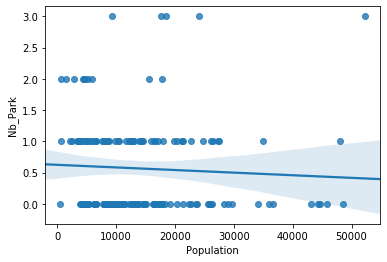

In [387]:
# Let's see if the relation between the two variables is correlated
sns.regplot(x="Population", y="VenueCategory", data=df_grp)

In [58]:
df_grp["Park"]=district_grp["VenueCategory"]*1000 
#Here we will ponderate our Variable Number of Parks to make it visibile in the Graph below and remove it later for clustering

In [59]:
import matplotlib.pyplot as plt

In [60]:
import seaborn as sns

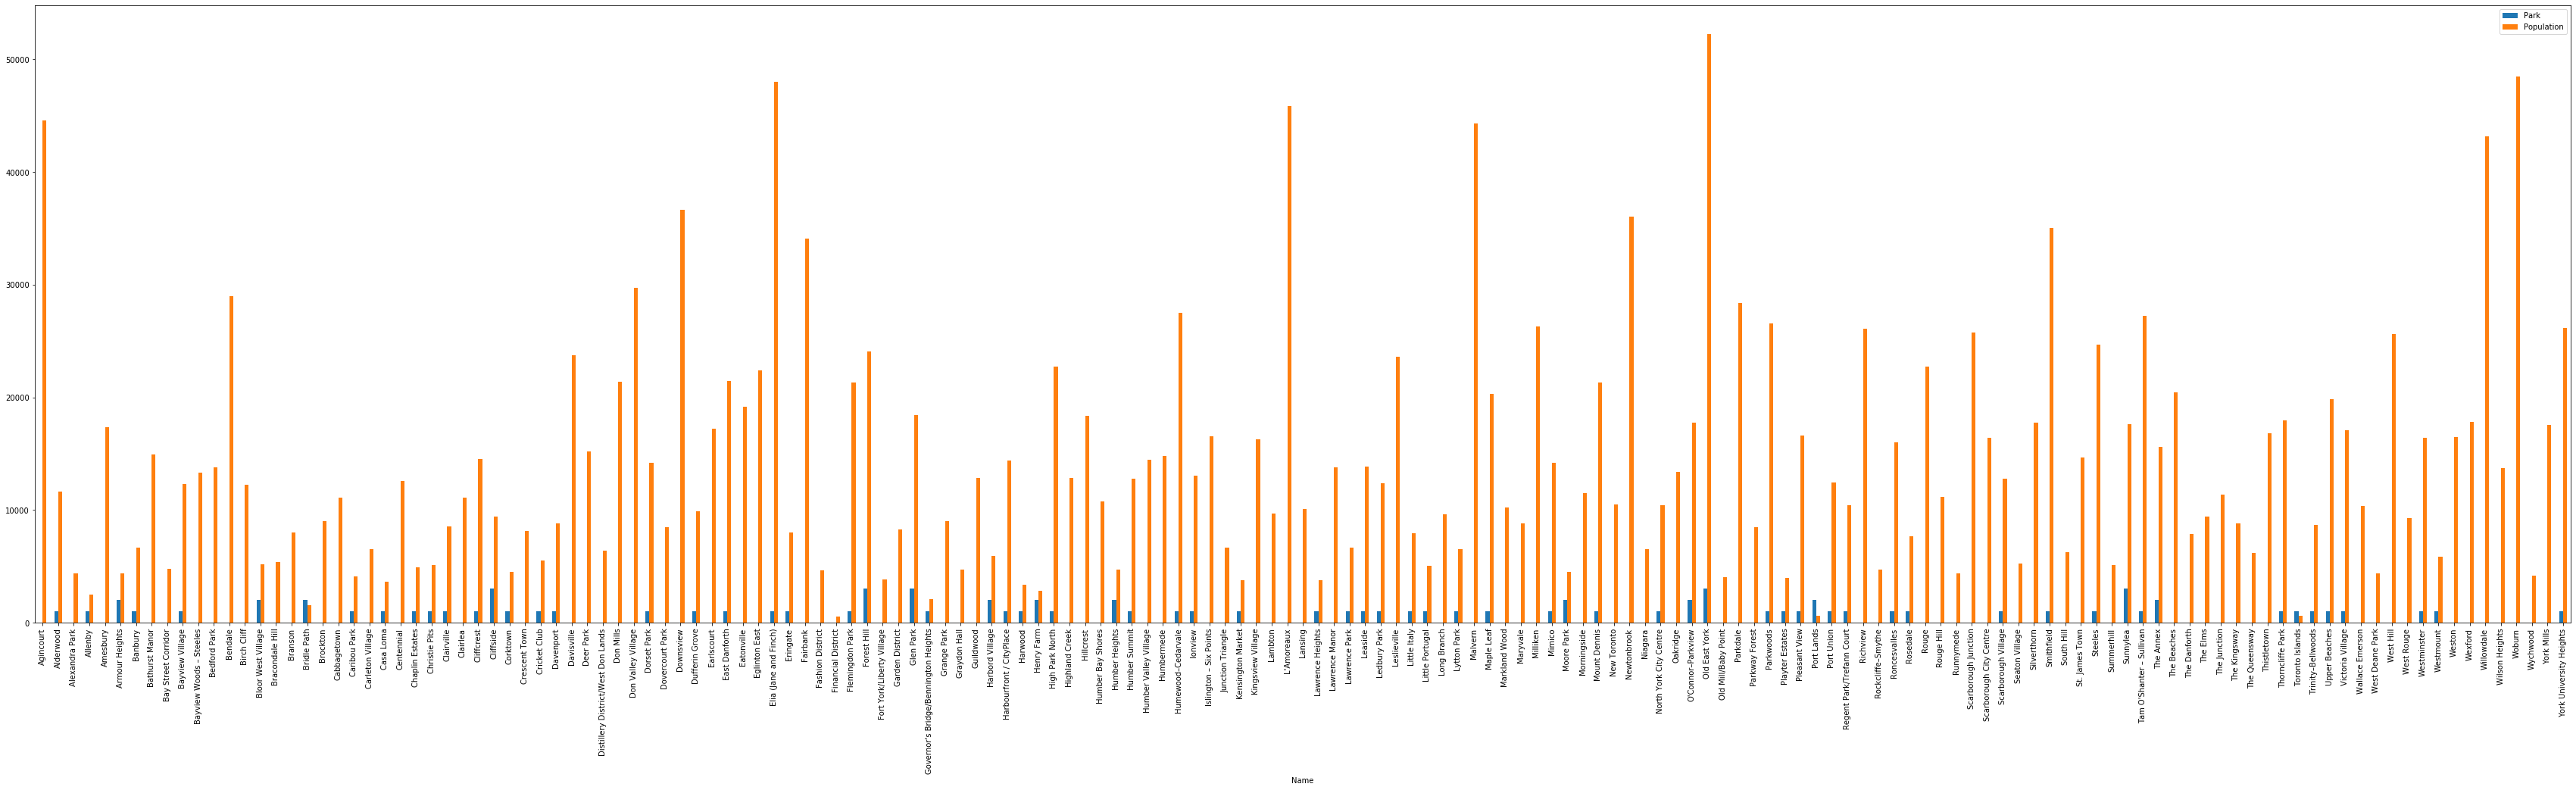

In [61]:
#Draw graph
df_grp[['Park','Population']].plot(kind='bar',figsize=(60,15))

### We can see that there is some Districts with no Park Aroud so we Have some Potentiel there based just on Population criteria

For Clustering K-Means Accept only numerical features

In [64]:
df_grp

,Population,VenueCategory,Park
Name,,,
Agincourt,44577,0.0,NaN
Alderwood,11656,1.0,1000.0
Alexandra Park,4355,0.0,NaN
Allenby,2513,1.0,1000.0
Amesbury,17318,0.0,NaN
...,...,...,...
Wilson Heights,13732,0.0,NaN
Woburn,48507,0.0,NaN
Wychwood,4182,0.0,NaN


We will rename Column VenueCategory to Nb_Park for more lisibility

In [67]:
district_grp=district_grp.rename(columns={"VenueCategory":"Nb_Park"})

In [68]:
df_grp=df.set_index('Name').join(district_grp, on='Name').fillna(0)

In [70]:
df_grp.head()

,Population,Latitude,Longitude,Nb_Park
Name,,,,
Agincourt,44577,43.601717,-79.545232,0.0
Alderwood,11656,43.650787,-79.404318,1.0
Alexandra Park,4355,43.711351,-79.553424,0.0
Allenby,2513,43.706162,-79.483492,1.0
Amesbury,17318,43.743944,-79.430851,0.0


<div id="5">
    <h2>5- Clustering Districts using k-means clustering to choose in which cluster we will choose our district</h2> 
</div>

In [71]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

In [72]:
X = df_grp[["Nb_Park","Population"]].values

In [73]:
#Transforming our dataset
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[-0.75926821,  2.92994021],
       [ 0.58595699, -0.24611432],
       [-0.75926821, -0.95047853],
       [ 0.58595699, -1.12818553],
       [-0.75926821,  0.30012731]])

Initialize KMeans with these parameters, where the output parameter is called k_means.

In [74]:
from sklearn.cluster import KMeans 
k_means = KMeans(init="k-means++", n_clusters=3, n_init=12)
k_means.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=12, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [75]:
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_
k_means_labels

array([2, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 2, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 2, 1, 1, 1, 2, 0, 1, 2, 0, 1,
       0, 1, 1, 2, 0, 2, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 2, 0, 1, 1, 0, 1, 1, 2, 1, 0, 1, 0, 0, 0, 2,
       0, 0, 1, 0, 2, 0, 1, 1, 2, 0, 0, 1, 0, 1, 2, 1, 0, 1, 0, 2, 1, 2,
       1, 2, 0, 0, 0, 0, 0, 2, 1, 0, 0, 2, 1, 1, 2, 1, 0, 1, 1, 2, 1, 1,
       2, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 2, 1, 0,
       0, 1, 1, 2, 1, 2, 1, 1, 2], dtype=int32)

In [76]:
# add clustering labels to our fisrt dataset to have for each District the cluster predicted below
df_grp.insert(0, 'Cluster Labels', k_means.labels_)

In [77]:
#Function to affect color to each cluster: used 5 colors to try different iterations 3,4,5 Clusters 
def color_producer(k_means_labels):
    if k_means_labels == 0:
        return 'green'
    elif k_means_labels == 1:
        return 'blue'
    else:
        return 'red'

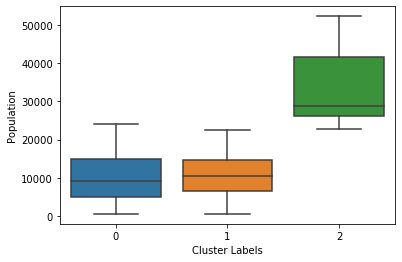

In [78]:
sns.boxplot(x="Cluster Labels", y="Population", data=df_grp)

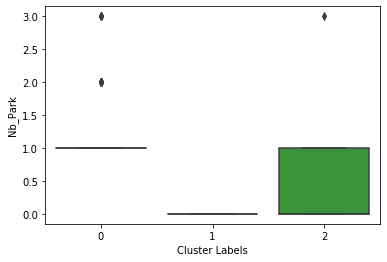

In [79]:
sns.boxplot(x="Cluster Labels", y="Nb_Park", data=df_grp)

<div id="6">
    <h2>6- Using the Folium library to visualize the neighborhoods, venues , clusters in toronto</h2> 
</div>

#### We should choose a place for the Park in Cluster2 with a High Population and Nb_Park is minimum 

In [80]:
# create map
map_clusters = folium.Map(location=[toro_latitude, toro_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(3)
ys = [i + x + (i*x)**2 for i in range(3)]
# add markers to the map
markers_colors = []
for lat, lon, cluster, pop, nb in zip(df_grp['Latitude'], df_grp['Longitude'], df_grp['Cluster Labels'],df_grp['Population'],df_grp['Nb_Park']):
    label = folium.Popup(' Population ' + str(pop)+' ,Nb_Park ' + str(nb)+', Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        fill_color=color_producer(cluster),
        fill=True,
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

### Conclusion 

Using some criteria such as Population and Number of existing Parks Neighbors to choose the right District where we can implement Our Park in this iteration we got these first results:

•	Districts where the best Place should be implemented based on the Population are those in Cluster-2 with Maximum Population and Minimum of Parks.
•	Districts where there is already a high competition, to be eliminated in a next iteration with more criteria.

By adding more criteria and more data we could filter these districts in Cluster-2 again in order to get the best District to implement the new Park.


## Thank you for reviewing my Humble work!